In [46]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import scipy.io as sio
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

%matplotlib inline

# Data Processing

In [2]:
# only for one stock
cleaned_close = sio.loadmat('../Pcleaned.mat')['P']
macd = pd.read_csv('../macd.csv').dropna()
rsi = pd.read_csv('../rsi.csv').dropna()
momentum = pd.read_csv('../momentum.csv').dropna()

In [3]:
cleaned_close_stock_1 = cleaned_close[:, 0].reshape(-1,4)
sell_indices = np.argmax(cleaned_close_stock_1, axis=1)
buy_indices = np.argmin(cleaned_close_stock_1, axis=1)
# buy=-1, hold=0, sell=1, 
labels = np.zeros(cleaned_close_stock_1.shape)
labels[np.arange(len(cleaned_close_stock_1)), sell_indices] = int(2)
labels[np.arange(len(cleaned_close_stock_1)), buy_indices] = int(1)
cleaned_close_stock_1_df = pd.DataFrame({'Close': cleaned_close[:, 0], 
                                         'Label': labels.flatten()})

In [4]:
def label_race(row):
    if row['Label'] == 2.0 :
        return 'Sell'
    elif row['Label'] == 0.0 :
        return 'Hold'
    elif row['Label'] == 1.0 :
        return 'Buy'

In [5]:
cleaned_close_stock_1_df['Action'] = cleaned_close_stock_1_df.apply(lambda row: 
                                                            label_race(row), axis=1)

In [6]:
cleaned_close_stock_1_df.head()

,Close,Label,Action
0,11.36,2.0,Sell
1,11.32,0.0,Hold
2,10.88,0.0,Hold
3,10.82,1.0,Buy
4,10.98,0.0,Hold


## Train Test Split

In [7]:
ytrain_data_stock_1 = cleaned_close_stock_1_df[25:int(0.8*len(cleaned_close_stock_1_df))]['Label'].values
ytest_data_stock_1 = cleaned_close_stock_1_df[int(0.8*len(cleaned_close_stock_1_df)):-1]['Label'].values

xtrain_rsi = rsi[0:int(0.8*len(cleaned_close_stock_1_df))-25]['RelativeStrengthIndex'].values
xtest_rsi = rsi[int(0.8*len(cleaned_close_stock_1_df))-25:-1]['RelativeStrengthIndex'].values

xtrain_macd = macd[0:int(0.8*len(cleaned_close_stock_1_df))-25]['Close'].values
xtest_macd = macd[int(0.8*len(cleaned_close_stock_1_df))-25:-1]['Close'].values

xtrain_momentum = momentum[0:int(0.8*len(cleaned_close_stock_1_df))-25]['Close'].values
xtest_momentum = momentum[int(0.8*len(cleaned_close_stock_1_df))-25:-1]['Close'].values

In [8]:
ohe = OneHotEncoder(categories='auto')
ytrain_data_stock_1 = ytrain_data_stock_1.reshape(-1, 1)
ytrain_data_stock_1 = ohe.fit_transform(ytrain_data_stock_1).toarray()
ytest_data_stock_1 = ytest_data_stock_1.reshape(-1, 1)
ytest_data_stock_1 = ohe.fit_transform(ytest_data_stock_1).toarray()

In [9]:
X_train = np.array([xtrain_rsi, xtrain_macd, xtrain_momentum]).reshape(-1, 3)
X_test = np.array([xtest_rsi, xtest_macd, xtest_momentum]).reshape(-1, 3)

In [10]:
X_train.shape

(1312, 3)

# Neural Network

In [11]:
model = Sequential()
model.add(Dense(64, input_dim=3, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
history = model.fit(X_train, ytrain_data_stock_1, 
                    validation_data=(X_test,ytest_data_stock_1), epochs=100, batch_size=64)

Train on 1312 samples, validate on 334 samples
Epoch 1/100
1312/1312 [==============================] - 1s 396us/step - loss: 2.5270 - acc: 0.3994 - val_loss: 1.2772 - val_acc: 0.3503
Epoch 2/100
1312/1312 [==============================] - 0s 70us/step - loss: 1.1849 - acc: 0.4512 - val_loss: 1.1398 - val_acc: 0.4521
Epoch 3/100
1312/1312 [==============================] - 0s 69us/step - loss: 1.1227 - acc: 0.4543 - val_loss: 1.1453 - val_acc: 0.4192
Epoch 4/100
1312/1312 [==============================] - 0s 72us/step - loss: 1.1008 - acc: 0.4672 - val_loss: 1.0983 - val_acc: 0.4731
Epoch 5/100
1312/1312 [==============================] - 0s 73us/step - loss: 1.0862 - acc: 0.4710 - val_loss: 1.0983 - val_acc: 0.4760
Epoch 6/100
1312/1312 [==============================] - 0s 71us/step - loss: 1.0576 - acc: 0.4817 - val_loss: 1.0976 - val_acc: 0.4880
Epoch 7/100
1312/1312 [==============================] - 0s 71us/step - loss: 1.0447 - acc: 0.4985 - val_loss: 1.0723 - val_acc: 0.4701


# Prediction

In [29]:
y_pred = model.predict(X_test)
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
test = list()
for i in range(len(ytest_data_stock_1)):
    test.append(np.argmax(ytest_data_stock_1[i]))

In [30]:
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 47.90419161676647


In [58]:
confusion_matrix = np.zeros([3,3])

for i in range(len(pred)):
    confusion_matrix[int(test[i]), int(pred[i])] += 1

confusion_matrix_df = pd.DataFrame(confusion_matrix, columns=['Hold', 'Buy', 'Sell'],
                                  index=['Hold', 'Buy', 'Sell'])

In [59]:
confusion_matrix_df

,Hold,Buy,Sell
Hold,153.0,3.0,13.0
Buy,75.0,2.0,6.0
Sell,77.0,0.0,5.0


In [66]:
test.count(0), test.count(1), test.count(2)

(169, 83, 82)

In [67]:
pred.count(0), pred.count(1), pred.count(2)

(305, 5, 24)

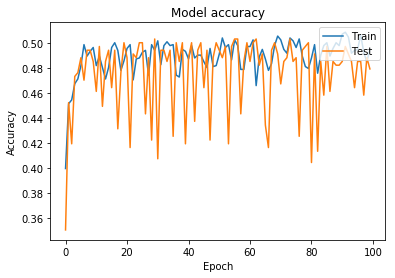

In [63]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

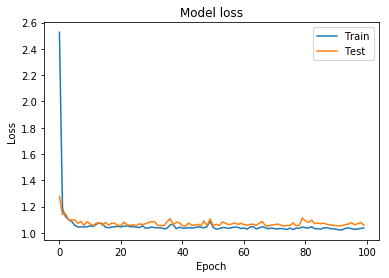

In [60]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper right') 
plt.show()

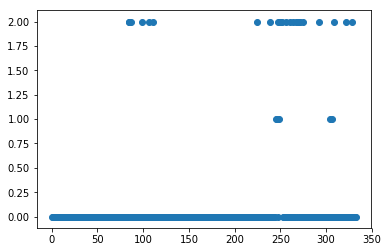

In [18]:
plt.scatter(np.arange(len(pred)), pred)

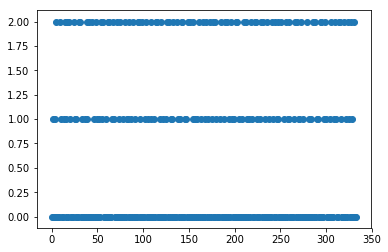

In [19]:
plt.scatter(np.arange(len(test)), test)